# Predicting Workload

Epoch 1/50
81/81 [==============================] - 15s 93ms/step - loss: 0.0344 - val_loss: 0.0092
Epoch 2/50
81/81 [==============================] - 5s 56ms/step - loss: 0.0097 - val_loss: 0.0052
Epoch 3/50
81/81 [==============================] - 5s 66ms/step - loss: 0.0076 - val_loss: 0.0034
Epoch 4/50
81/81 [==============================] - 6s 72ms/step - loss: 0.0061 - val_loss: 0.0025
Epoch 5/50
81/81 [==============================] - 5s 56ms/step - loss: 0.0052 - val_loss: 0.0020
Epoch 6/50
81/81 [==============================] - 4s 50ms/step - loss: 0.0049 - val_loss: 0.0017
Epoch 7/50
81/81 [==============================] - 5s 59ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 8/50
81/81 [==============================] - 4s 52ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 9/50
81/81 [==============================] - 5s 61ms/step - loss: 0.0045 - val_loss: 0.0015
Epoch 10/50
81/81 [==============================] - 5s 56ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 11

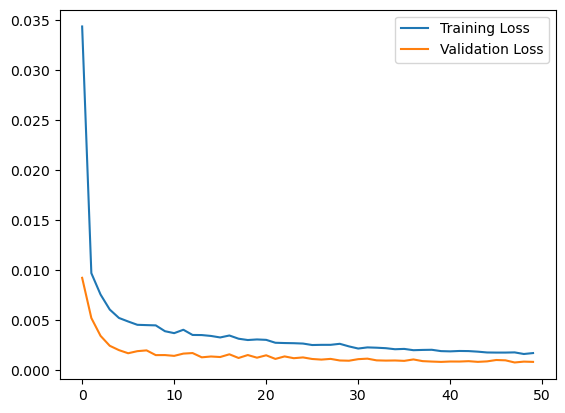

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import l2
from tensorflow import keras
from sklearn.metrics import mean_squared_error

def prepare_data(seq,num):
  x=[]
  y=[]
  for i in range(0,(len(seq)-num),1):
    
    input_ = seq[i:i+num]
    output  = seq[i+num]
    
    x.append(input_)
    y.append(output)
    
  return np.array(x), np.array(y)

data=pd.read_csv('../Utilities\csv\metrics_2024-09-11-16-52-02/1_metrics.csv')
cpu_usage = data['value'].values

# Number of samples per window (4 sequences is 1 minute)
num = 40
sample = cpu_usage[:num]

x,y= prepare_data(cpu_usage,num)

ind = int(0.7 * len(x))
x_tr = x[:ind]
y_tr = y[:ind]
x_val=x[ind:]
y_val=y[ind:]

#normalize the inputs
x_scaler= MinMaxScaler(feature_range=(0, 1))
x_tr = x_scaler.fit_transform(x_tr)
x_val= x_scaler.transform(x_val)

#reshaping the output for normalization
y_tr=y_tr.reshape(len(y_tr),1)
y_val=y_val.reshape(len(y_val),1)

#normalize the output
y_scaler=MinMaxScaler(feature_range=(0, 1))
y_tr = y_scaler.fit_transform(y_tr)[:,0]
y_val = y_scaler.transform(y_val)[:,0]

#reshaping input data
x_tr= x_tr.reshape(x_tr.shape[0],x_tr.shape[1],1)
x_val= x_val.reshape(x_val.shape[0],x_val.shape[1],1)

# def traffic_prediction_lstm():
#     model = Sequential()
#     model.add(Bidirectional(LSTM(30, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), input_shape=(num, 1)))
#     model.add(Bidirectional(LSTM(20, return_sequences=True, kernel_regularizer=l2(0.01))))
#     model.add(Bidirectional(LSTM(10, return_sequences=False, kernel_regularizer=l2(0.01))))
#     model.add(BatchNormalization())
#     model.add(Dense(10, activation='relu'))
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer='adam', loss='mse')
#     # Learning Rate Scheduler
#     lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
#     # Print model summary
#     model.summary()
#     return model, lr_scheduler


# lstm_model, lr_scheduler = traffic_prediction_lstm()
# # Early Stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# # Fit the model
# history = lstm_model.fit(x_tr, y_tr,
#                           epochs=20,
#                           batch_size=10,
#                           validation_data=(x_val, y_val),
#                           callbacks=[early_stopping, lr_scheduler, model_checkpoint])

# lstm_model.load_weights('best_model.hdf5')

def traffic_prediction_lstm():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(num, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_model= traffic_prediction_lstm()

history = lstm_model.fit(
    x_tr, y_tr,
    epochs=50,
    batch_size=32,
    validation_data=(x_val, y_val),
    verbose=1
)

mse = lstm_model.evaluate(x_val,y_val)
print("Mean Square Error:",mse)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 330ms/step
Mean Squared Error: 0.0016479701131124462


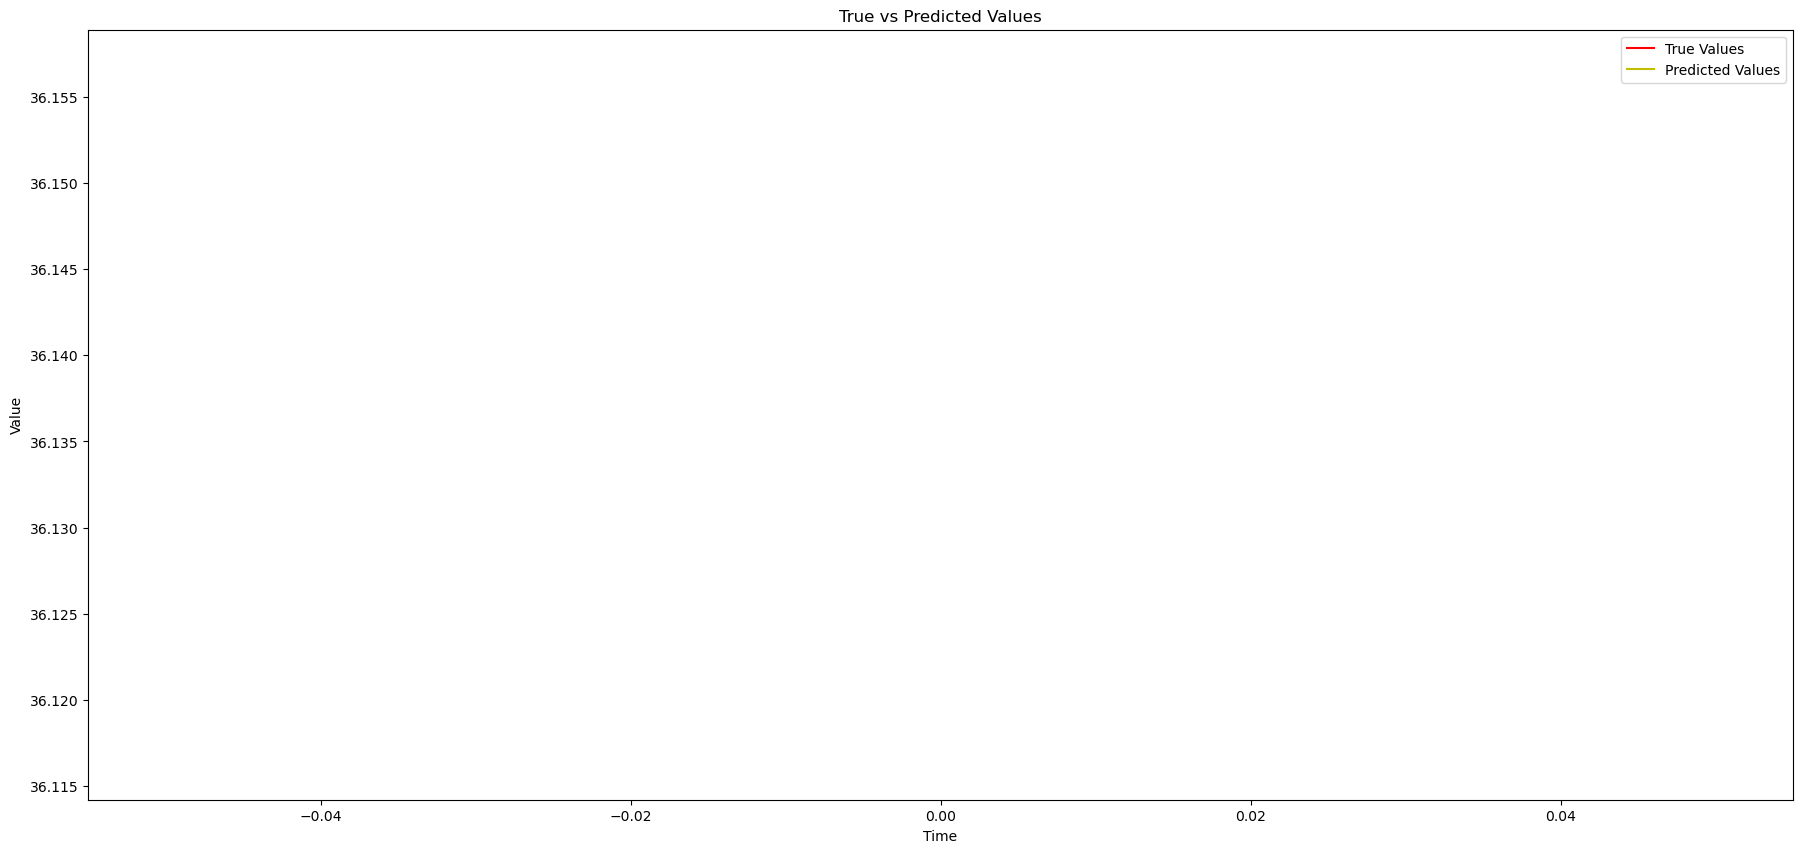

In [27]:
def forecast(x_val, no_of_pred, ind):
    predictions = []
    temp = x_val[ind].copy()  # Ensure we do not modify the original data

    for _ in range(no_of_pred):
        temp = temp.reshape(1, -1, 1)  # Ensure correct shape for prediction
        pred = lstm_model.predict(temp)[0][0]
        predictions.append(pred)
        
        # Update temp with the new prediction
        temp = np.roll(temp, -1)  # Roll the array to the left
        temp[-1, 0, 0] = pred  # Insert the prediction at the end
    return np.array(predictions)

# Number of predictions in 15s intervals (10 mins)
no_of_pred = 1
# number hours of data to predict from
ind = int(1 * 240)
y_pred= forecast(x_val,no_of_pred,ind).reshape(-1, 1)
y_true = y_val[ind:ind+(no_of_pred)].reshape(-1, 1)

# Lets convert back the normalized values to the original dimensional space
y_true= y_scaler.inverse_transform(y_true)
y_pred= y_scaler.inverse_transform(y_pred)

mse = mean_squared_error(y_true, y_pred)
print("Mean Squared Error:", mse)

# Confirming difference between true and predicted values
# for x in range(len(y_true)):
#     diff = y_true[x] - y_pred[x]
#     print(diff)

def plot(y_true, y_pred):
    ar = np.arange(len(y_true))
    plt.figure(figsize=(22, 10))
    plt.plot(ar, y_true, 'r', label='True Values')
    plt.plot(ar, y_pred, 'y', label='Predicted Values')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('True vs Predicted Values')
    plt.show()
plot(y_true,y_pred)

# Predicting number of replicas

1/1 [==============================] - 0s 47ms/step
Predicted CPU Percentage:  3.358562

Predicted Replicas:  2



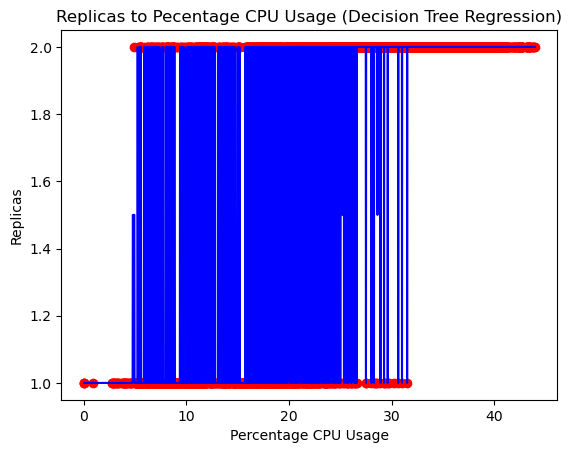

In [30]:
from sklearn.tree import DecisionTreeRegressor

dtr_cpu_usage = pd.read_csv('../Utilities\csv\metrics_2024-09-11-16-52-02/1_metrics.csv')
dtr_replicas = pd.read_csv('../Utilities\csv\metrics_2024-09-11-16-52-02/2_metrics.csv')
dtr_data = pd.merge(dtr_cpu_usage, dtr_replicas, on='timestamp')
dtr_data.rename(columns={'value_x': 'cpu_usage', 'value_y': 'replicas'}, inplace=True)
dtr_data_arr = np.array(dtr_data)

dtr_arr_cpu = dtr_data_arr[:, 1:2]
dtr_arr_replicas = dtr_data_arr[:, 2:3]

regressor = DecisionTreeRegressor(random_state = 0)

regressor.fit(dtr_arr_cpu, dtr_arr_replicas)

# Make a CPU usage prediction
# forecast(<data to predict from>, <number of predictions>, <size of data to predict from>)
real_prediction = forecast(dtr_cpu_usage['value'],1,240).reshape(-1, 1)

transformed_pred = y_scaler.inverse_transform(real_prediction)

# predicting a new value  
y_pred_replicas = regressor.predict(transformed_pred)

# Print predicted CPU percentage
print("Predicted CPU Percentage: % f\n"% real_prediction)
# print the predicted replicas
print("Predicted Replicas: % d\n"% y_pred_replicas)

# arange for creating a range of values 
# from min value of X to max value of X 
# with a difference of 0.01 between two 
# consecutive values 
X_grid = np.arange(min(dtr_arr_cpu), max(dtr_arr_cpu), 0.01) 

# reshape for reshaping the data into 
# a len(X_grid)*1 array, i.e. to make 
# a column out of the X_grid values 
X_grid = X_grid.reshape((len(X_grid), 1)) 

# scatter plot for original data 
plt.scatter(dtr_arr_cpu, dtr_arr_replicas, color = 'red') 

# plot predicted data 
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue') 

# specify title 
plt.title('Replicas to Pecentage CPU Usage (Decision Tree Regression)') 

# specify X axis label 
plt.xlabel('Percentage CPU Usage') 

# specify Y axis label 
plt.ylabel('Replicas') 

# show the plot 
plt.show() 

